# Gesture Recognition
##### In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [5]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
import datetime
import os

##### We set the random seed so that the results don't vary drastically.



In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [7]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
#unzipping the dataset in the drive
!unzip "/content/gdrive/MyDrive/AIML/Project_data.zip" > /dev/null

##### In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error

In [9]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 15

In [10]:
!ls

gdrive	Project_data  sample_data


In [11]:
image_x_shape = 100
image_y_shape = 100

# Generator
##### This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [12]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0, 30, 3)) #create a list of image numbers you want to use for a particular video
    x, y, z = len(img_idx), image_x_shape, image_y_shape
    while True:
        t = np.random.permutation(folder_list)
        total_folders = len(folder_list)
        num_batches = total_folders // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, 
                                        #(y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    resizedImage = resize(image, (y, z),anti_aliasing=True)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = resizedImage[:, :, 0] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resizedImage[:, :, 1] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resizedImage[:, :, 2] / 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        missing_count = total_folders - (num_batches * batch_size)
        for folder in range(missing_count):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                resizedImage = resize(image, (y, z),anti_aliasing=True)
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes

                batch_data[folder,idx,:,:,0] = resizedImage[:, :, 0] / 255 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = resizedImage[:, :, 1] / 255 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = resizedImage[:, :, 2] / 255 #normalise and feed in the image

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels
    # write the code for the remaining data points which are left after full batches

##### Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


# Model
##### Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [14]:
from keras.models import Sequential, Model
from sklearn.metrics import roc_auc_score
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv2D, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers, regularizers
from keras.regularizers import l2
import keras

In [15]:
reduceLR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2,
                             verbose = 1, mode = "auto", cooldown = 0)

In [16]:
class DecayLR(keras.callbacks.Callback):
    
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.lr_history = []
        self.decay_epoch = decay_epoch
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)
        
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [17]:
class Convolution2DWithGRU():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_y_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
#         cnn_model.add(Dense(20))
        
        cnn_model.add(Dense(16))
        cnn_model.add(Dropout(.50))
        cnn_model.add(GRU(64, return_sequences=False))
#         cnn_model.add(Dense(32))
        cnn_model.add(Dense(5, activation='softmax'))
        return cnn_model

##### Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [18]:
obj = Convolution2DWithGRU()
model = obj.model(batch_size)
optimiser = optimizers.Adam() #write your optimizer

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 100, 100, 32)  128      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 100, 100, 32)  0        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 49, 49, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 49, 49, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 49, 49, 32)   9

##### Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [19]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [20]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR(base_lr=0.1) # write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]
# roc_callback = RocCallback()
callbacks_list = [checkpoint,reduceLR]

##### The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

##### Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [22]:
#_generator
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 15
Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 4.1910 - categorical_accuracy: 0.2178Source path =  Project_data/val ; batch size = 15

Epoch 1: saving model to model_init_2023-03-1706_45_14.821926/model-00001-4.19098-0.21778-3.00279-0.14286.h5
45/45 [==============================] - 75s 1s/step - loss: 4.1910 - categorical_accuracy: 0.2178 - val_loss: 3.0028 - val_categorical_accuracy: 0.1429 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 2.4243 - categorical_accuracy: 0.2430
Epoch 2: saving model to model_init_2023-03-1706_45_14.821926/model-00002-2.42432-0.24296-2.08475-0.17143.h5
45/45 [==============================] - 58s 1s/step - loss: 2.4243 - categorical_accuracy: 0.2430 - val_loss: 2.0847 - val_categorical_accuracy: 0.1714 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 1.8794 - categorical_accuracy: 0.2830
Epoch 3: saving model to model

In [23]:
print(model.history)

In [24]:
import matplotlib.pyplot as plt

class PlotMetrics():
    
    def draw(self, history):
        # ===> loss summary
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
        f.set_figheight(5)
        f.set_figwidth(15)
        
        ax1.plot(history.history['val_categorical_accuracy'])
        ax1.plot(history.history['categorical_accuracy'])
        ax1.title.set_text('model accuracy')
        ax1.set_ylabel('accuracy')
        ax1.set_xlabel('epoch')
        ax1.legend(['train', 'test'], loc='upper left')
        
        ax2.plot(history.history['val_loss'])
        ax2.plot(history.history['loss'])
        ax2.title.set_text('Loss function')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('epoch')
        ax2.legend(['train', 'test'], loc='upper left')
        plt.show()
        

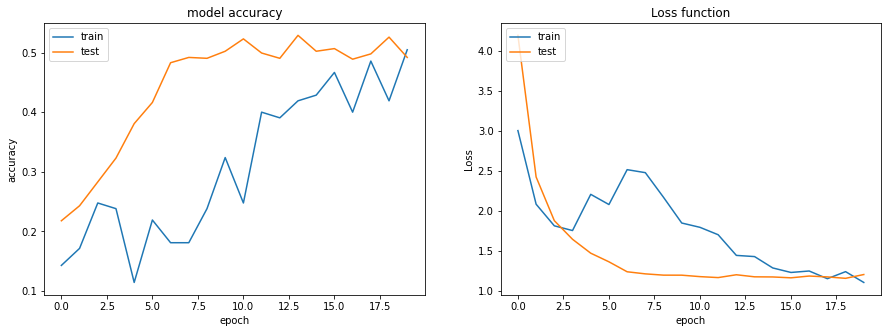

In [25]:
obj= PlotMetrics()
obj.draw(model.history)

# CONV3D Model:

In [26]:
class convolution3D():
    def __init__(self):
        return None
    
    def model2(self, batch_size):
        model = Sequential()
      
        model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, 100, 100, 3)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 1), data_format="channels_first"))
                               #strides=None, dim_ordering='th'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format="channels_first"))
                               #strides=None, dim_ordering='th'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2),data_format="channels_first"))
                               #strides=None, dim_ordering='th'))
        model.add(BatchNormalization())
        
       
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        return model

In [27]:
obj = convolution3D()
conv3d_model = obj.model2(batch_size)
conv3d_optimiser = optimizers.Adam() #write your optimizer

conv3d_model.compile(optimizer=conv3d_optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 100, 100, 8)   656       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 50, 50, 8)     0         
 )                                                               
                                                                 
 batch_normalization_3 (Batc  (None, 5, 50, 50, 8)     32        
 hNormalization)                                                 
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 50, 50, 16)     3472      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 25, 25, 16)    0         
 3D)                                                             
                                                      

In [28]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_3d-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR(base_lr=0.1) # write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]
# roc_callback = RocCallback()
callbacks_list = [reduceLR,checkpoint]

In [29]:

conv3d_model_history = conv3d_model.fit_generator(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

<ipython-input-29-2c8e93ff3bf8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  conv3d_model_history = conv3d_model.fit_generator(train_generator,


Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 3.0712 - categorical_accuracy: 0.2148
Epoch 1: saving model to model_init_2023-03-1706_45_14.821926/model_3d-00001-3.07115-0.21481-2.51727-0.17143.h5
45/45 [==============================] - 60s 1s/step - loss: 3.0712 - categorical_accuracy: 0.2148 - val_loss: 2.5173 - val_categorical_accuracy: 0.1714 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 2.4842 - categorical_accuracy: 0.2859
Epoch 2: saving model to model_init_2023-03-1706_45_14.821926/model_3d-00002-2.48420-0.28593-2.49334-0.17143.h5
45/45 [==============================] - 55s 1s/step - loss: 2.4842 - categorical_accuracy: 0.2859 - val_loss: 2.4933 - val_categorical_accuracy: 0.1714 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 2.3685 - categorical_accuracy: 0.3378
Epoch 3: saving model to model_init_2023-03-1706_45_14.821926/model_3d-00003-2.36849-0.33778-2.44122-0.26667.h5
45/45 [=======

{'loss': [3.0711519718170166, 2.4841978549957275, 2.36848783493042, 2.2648816108703613, 2.1492247581481934, 2.105013608932495, 1.98411226272583, 1.9643272161483765, 1.8655222654342651, 1.845130205154419, 1.7754660844802856, 1.733903169631958, 1.6685845851898193, 1.6127736568450928, 1.5785185098648071, 1.5787029266357422, 1.562305212020874, 1.5215332508087158, 1.4748008251190186, 1.5099267959594727], 'categorical_accuracy': [0.21481481194496155, 0.2859259247779846, 0.3377777636051178, 0.36000001430511475, 0.4000000059604645, 0.4533333480358124, 0.4399999976158142, 0.4577777683734894, 0.4681481420993805, 0.4725925922393799, 0.517037034034729, 0.5644444227218628, 0.5451852083206177, 0.5970370173454285, 0.5866666436195374, 0.6325926184654236, 0.614814817905426, 0.6474074125289917, 0.6311110854148865, 0.6237037181854248], 'val_loss': [2.51727294921875, 2.4933433532714844, 2.4412155151367188, 2.3942058086395264, 2.280139446258545, 2.264517068862915, 2.1199417114257812, 2.151553153991699, 1.8

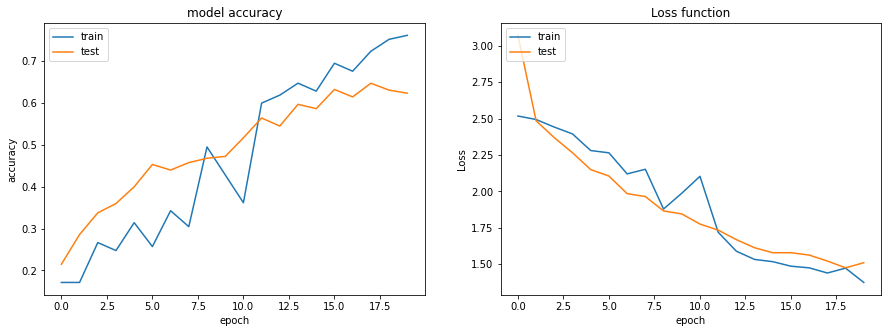

In [30]:
print(conv3d_model_history.history)
obj= PlotMetrics()
obj.draw(conv3d_model_history)

In [33]:
!cd model*

In [35]:
!ls model_init_2023-03-1706_45_14.821926

model-00001-4.19098-0.21778-3.00279-0.14286.h5
model-00002-2.42432-0.24296-2.08475-0.17143.h5
model-00003-1.87939-0.28296-1.81498-0.24762.h5
model-00004-1.64714-0.32296-1.75611-0.23810.h5
model-00005-1.47368-0.38074-2.20767-0.11429.h5
model-00006-1.36609-0.41630-2.08055-0.21905.h5
model-00007-1.24180-0.48296-2.51556-0.18095.h5
model-00008-1.21565-0.49185-2.47818-0.18095.h5
model-00009-1.19965-0.49037-2.17016-0.23810.h5
model-00010-1.19929-0.50222-1.84989-0.32381.h5
model-00011-1.18123-0.52296-1.79624-0.24762.h5
model-00012-1.16924-0.49926-1.70379-0.40000.h5
model-00013-1.20459-0.49037-1.44608-0.39048.h5
model-00014-1.17881-0.52889-1.43124-0.41905.h5
model-00015-1.17711-0.50222-1.28944-0.42857.h5
model-00016-1.16630-0.50667-1.23324-0.46667.h5
model-00017-1.18853-0.48889-1.25142-0.40000.h5
model-00018-1.17766-0.49778-1.15537-0.48571.h5
model-00019-1.15994-0.52593-1.24331-0.41905.h5
model-00020-1.20738-0.49185-1.10864-0.50476.h5
model_3d-00001-3.07115-0.21481-2.51727-0.17143.h5
model_3d-0

In [36]:
!zip -r model_init_2023-03-1706_45_14.821926.zip model_init_2023-03-1706_45_14.821926

  adding: model_init_2023-03-1706_45_14.821926/ (stored 0%)
  adding: model_init_2023-03-1706_45_14.821926/model-00018-1.17766-0.49778-1.15537-0.48571.h5 (deflated 6%)
  adding: model_init_2023-03-1706_45_14.821926/model_3d-00009-1.86552-0.46815-1.87872-0.49524.h5 (deflated 10%)
  adding: model_init_2023-03-1706_45_14.821926/model-00006-1.36609-0.41630-2.08055-0.21905.h5 (deflated 6%)
  adding: model_init_2023-03-1706_45_14.821926/model_3d-00001-3.07115-0.21481-2.51727-0.17143.h5 (deflated 10%)
  adding: model_init_2023-03-1706_45_14.821926/model_3d-00008-1.96433-0.45778-2.15155-0.30476.h5 (deflated 10%)
  adding: model_init_2023-03-1706_45_14.821926/model-00013-1.20459-0.49037-1.44608-0.39048.h5 (deflated 6%)
  adding: model_init_2023-03-1706_45_14.821926/model-00011-1.18123-0.52296-1.79624-0.24762.h5 (deflated 6%)
  adding: model_init_2023-03-1706_45_14.821926/model-00003-1.87939-0.28296-1.81498-0.24762.h5 (deflated 7%)
  adding: model_init_2023-03-1706_45_14.821926/model-00008-1.215

In [37]:
!ls

gdrive					  Project_data
model_init_2023-03-1706_45_14.821926	  sample_data
model_init_2023-03-1706_45_14.821926.zip


In [39]:
from google.colab import files
files.download('model_init_2023-03-1706_45_14.821926.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>